In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path_to_files = "stock_data/"
# path_to_sentiments1 = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_sentiments = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_global_news = "news_sentiment_scores/2000-2024/sentiment_analysis_results_"

stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

interval = 14 # Time interval for Standard Moving Average calculation 
start_date = pd.to_datetime('2012-01-01').date()
end_date = pd.to_datetime('2023-01-01').date()



In [5]:
def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
    merged_data = {}
    X_features_ = None

    for symbol in stock_symbols:
        ## Load data
        df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
        df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")
        df_news = pd.read_csv(path_to_global_news + symbol + ".csv") 

        ## Convert date columns
        df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
        df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True).dt.date
        
        ## Rename columns
        rename_mapping1 = {
            'weighted positive sentiment score': 'Stock +ve Sentiment',
            'weighted negative sentiment score': 'Stock -ve Sentiment',
            'weighted neutral sentiment score': 'Stock Neutral',
            'weighted compound sentiment score': 'Stock Sentiment',
        }
        rename_mapping2 = {
            'weighted positive sentiment score': 'Global +ve Sentiment',
            'weighted negative sentiment score': 'Global -ve Sentiment',
            'weighted neutral sentiment score': 'Global Neutral',
            'weighted compound sentiment score': 'News Sentiment',
        }
        df_sentiment = df_sentiment.rename(columns=rename_mapping1)
        df_news = df_news.rename(columns=rename_mapping2)


        
        ## Filter by date range
        sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
        stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]
        news_filtered = df_news[(df_news['Date'] >= start_date) & (df_news['Date'] <= end_date)]

        ## Remove 'Ticker' column
        sentiment_filtered = sentiment_filtered.drop(columns=['Ticker'])
        news_filtered = news_filtered.drop(columns=['Ticker'])
        
        ## Merge stock and sentiment data on common dates
        merged_df = pd.merge(stock_filtered, sentiment_filtered, on='Date', how='inner')

        ## Merge news data, filling missing values with zeros
        merged_df = pd.merge(merged_df, news_filtered, on='Date', how='left')
        news_columns = news_filtered.columns.tolist()
        # news_columns.remove('Date')
        merged_df[news_columns] = merged_df[news_columns].fillna(0)

        ## Compute Features and assgin target variables 
        merged_df.sort_values('Date', inplace=True)

        merged_df['SMA'] = merged_df['Close'].rolling(window= interval).mean()
        merged_df['Difference'] = merged_df['Close'].diff()
        # merged_df['Trend'] = merged_df['Close'].diff().apply(categorize_change)
        merged_df['PD'] = merged_df['Close'].pct_change() * 100
        merged_df['Next Day Closing'] = merged_df['Close'].shift(-1)

        # Drop the first row where PD is NaN
        merged_df = merged_df.dropna(subset=['PD'])

        # Apply classify_price_difference function
        # merged_df['Price Movement'] = merged_df.apply(classify_price_difference, axis=1)

        X_features_ = merged_df.columns.tolist()
        merged_data[symbol] = merged_df.dropna()  # Drop NA after adding features
        
    return merged_data, X_features_


In [8]:
stock_data, Xfeatures = preprocess_and_merge_data(stock_symbols, start_date, end_date, interval)
stock_data['GOOG'].head(20)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock +ve Sentiment,Stock -ve Sentiment,Stock Neutral,Stock Sentiment,Global +ve Sentiment,Global -ve Sentiment,Global Neutral,News Sentiment,SMA,Difference,PD,Next Day Closing
13,2012-07-30,15.803062,15.965799,15.640322,15.709890,87795852,0.0,0.0,0.111000,0.000000,0.889000,0.653000,0.000000,0.000000,0.000000,0.000000,15.316371,0.533685,3.516589,16.398365
14,2012-08-13,16.085557,16.401843,16.067172,16.398365,131205956,0.0,0.0,0.031000,0.099395,0.909898,-0.582518,0.000000,0.000000,0.000000,0.000000,15.383011,0.688475,4.382428,17.197895
15,2012-09-11,17.341254,17.408089,17.168329,17.197895,75232938,0.0,0.0,0.111000,0.057000,0.832000,0.624900,0.000000,0.000000,0.000000,0.000000,15.476395,0.799530,4.875669,18.618816
16,2012-09-24,18.162153,18.635214,18.143520,18.618816,143086320,0.0,0.0,0.282000,0.000000,0.718000,0.962200,0.000000,0.270101,0.778891,-0.376388,15.766361,1.420921,8.262182,17.267712
17,2012-10-18,18.771866,18.868266,16.795644,17.267712,499561487,0.0,0.0,0.152560,0.118161,0.819924,0.164248,0.000000,0.000000,0.000000,0.000000,15.989102,-1.351105,-7.256663,18.422535
18,2013-01-10,18.456077,18.509993,18.224268,18.422535,73703226,0.0,0.0,0.078000,0.053000,0.868000,0.340000,0.000000,0.000000,1.000000,0.000000,16.226094,1.154823,6.687761,17.463245
19,2013-01-22,17.507720,17.524614,17.280630,17.463245,152264594,0.0,0.0,0.202000,0.059000,0.740000,0.562800,0.000000,0.000000,0.000000,0.000000,16.309699,-0.959290,-5.207153,18.423031
20,2013-01-23,18.286133,18.609373,18.281164,18.423031,237249950,0.0,0.0,0.173000,0.026000,0.801000,0.829900,0.000000,0.000000,0.000000,0.000000,16.470291,0.959785,5.496031,19.270267
21,2013-02-01,18.837953,19.295115,18.835470,19.270267,150405652,0.0,0.0,0.127000,0.000000,0.873000,0.659700,0.000000,0.000000,0.000000,0.000000,16.738268,0.847237,4.598791,20.835543
22,2013-03-05,20.595286,20.874055,20.594540,20.835543,162370331,0.0,0.0,0.125000,0.000000,0.875000,0.680800,0.000000,0.447000,0.553000,-0.844700,17.159455,1.565275,8.122748,19.711775


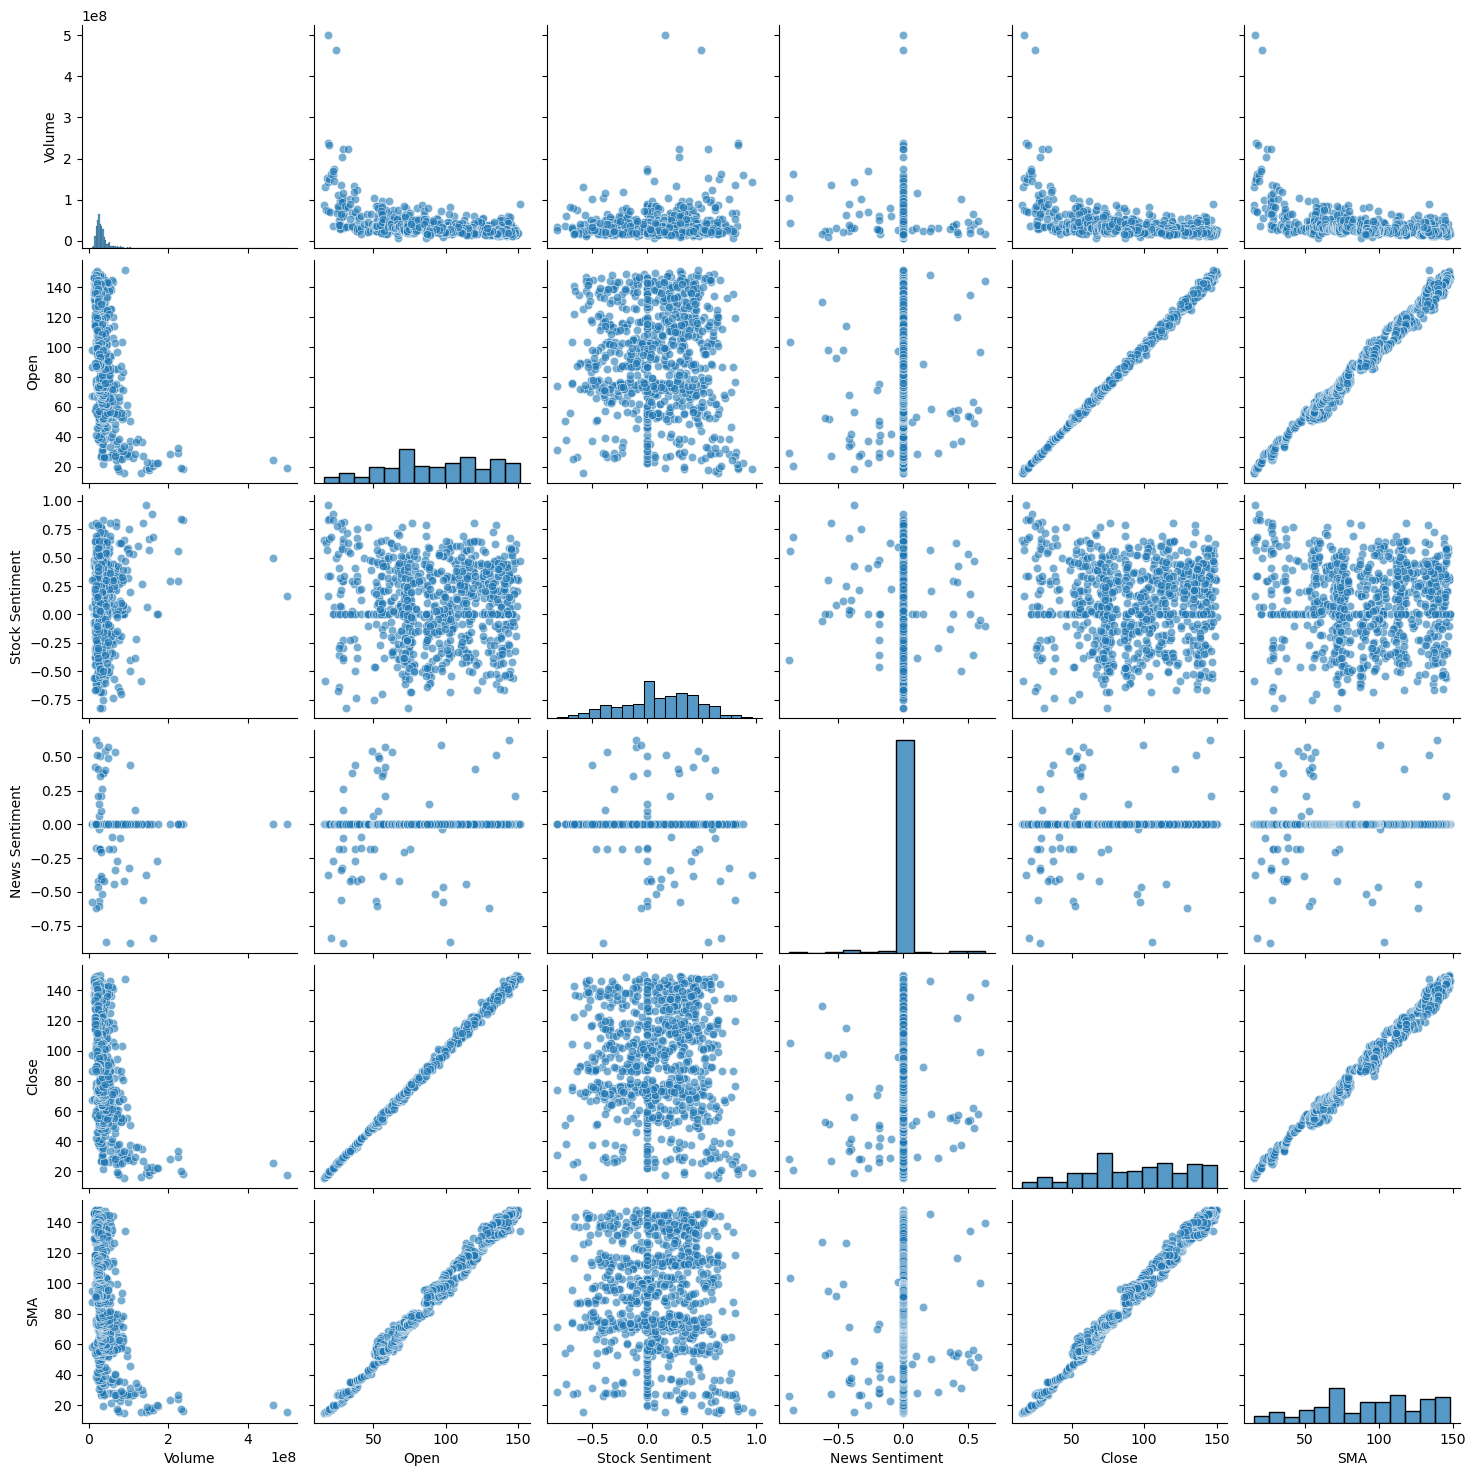

In [9]:


sns.pairplot(data = stock_data['GOOG'],
                x_vars = ['Volume', 'Open', 'Stock Sentiment', 'News Sentiment', 'Close', 'SMA'],
                y_vars = ['Volume', 'Open', 'Stock Sentiment', 'News Sentiment', 'Close', 'SMA'],
                plot_kws = {'alpha':.6})

plt.show()

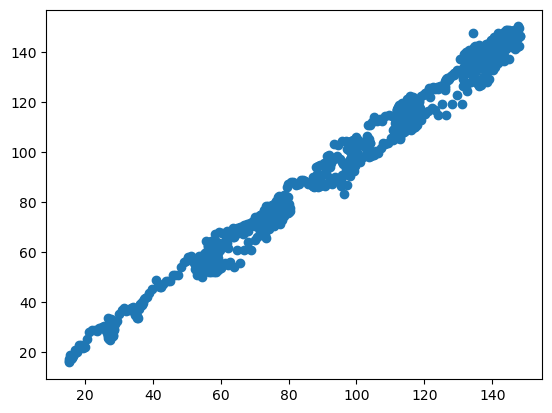

In [12]:
plt.scatter(stock_data['GOOG']['SMA'], stock_data['GOOG']['Close'])